<center><h2><b><u>PART-1</u></b></h2></center>
<p>
<b><u>DOMAIN:</u></b> Entertainment
</p>
<p>
  <b><u>CONTEXT:</u></b>: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene
</p>

In [1]:
import cv2
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_19
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.imagenet_utils import preprocess_input as imagenet_preprocess_input
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Flatten, Dropout, Input, Lambda
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from random import randint
from tqdm.notebook import tqdm
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam as adm , SGD as sgd
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow
import seaborn as sns
import h5py
import pickle
import tensorflow as tf
import warnings
import os
from tensorflow.keras import backend as K
import pdb
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
image_hight = 224
image_width = 224
alpha = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower


In [2]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def show_top_images_with_lables(images, lables, plot_random=True):
  columns = 4
  rows = 5
  fig=plt.figure(figsize=(12, 17))
  for i in range(1, columns*rows +1):
    index = None
    if plot_random == True:
      index = randint(0, (len(lables)-1))
    else:
      index = i
    fig.add_subplot(rows, columns, i).set_title(lables[index-1])
    plt.imshow(images[index-1], cmap='gray')
  return plt.show()

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [ ]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(image_hight, image_width, 3), include_top=False, alpha=alpha, weights="imagenet") # Load pre-trained mobilenet
    for layer in model.layers:
        layer.trainable = trainable

     
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((image_hight, image_width))(x)

    return Model(inputs=model.input, outputs=x)

In [ ]:
part_1_ds_path = '/content/drive/MyDrive/GreatLearning/CV-Project-2/Part 1- Train data - images.npy'
part_1_dataset = np.load(part_1_ds_path, allow_pickle=True)

In [ ]:
part_1_dataset.shape

(409, 2)

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


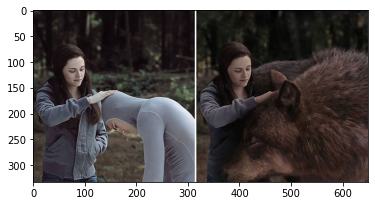

In [ ]:
plt.imshow(part_1_dataset[0][0])
print(part_1_dataset[0][1])

In [ ]:
actual_images = []
target_lables = []
masked_images = []
masked_target_lables = []
print("Preparing Dataset...")
for train_data in tqdm(part_1_dataset):
  img = train_data[0]
  fcs = train_data[1]
  rs_img = cv2.resize(img, (image_width, image_hight))
  try:
    rs_img = rs_img[:, :, :3]
    masked_image = np.zeros((image_hight, image_width))
    for fc in fcs:
      x1 = int(fc['points'][0]['x'] * image_hight)
      x2 = int(fc['points'][1]['x'] * image_hight)
      y1 = int(fc['points'][0]['y'] * image_hight)
      y2 = int(fc['points'][1]['y'] * image_hight)
      masked_image[y1:y2, x1:x2] = 1
    actual_images.append(rs_img)
    target_lables.append('Face')
    masked_images.append(masked_image)
    masked_target_lables.append('Segmented Face')
  except:
    continue
actual_images = np.array(actual_images) 
masked_images = np.array(masked_images)
target_lables = np.array(target_lables)
masked_target_lables = np.array(masked_target_lables)
print("Done")

Preparing Dataset...



Done


In [ ]:
actual_images.shape, masked_images.shape

((408, 224, 224, 3), (408, 224, 224))

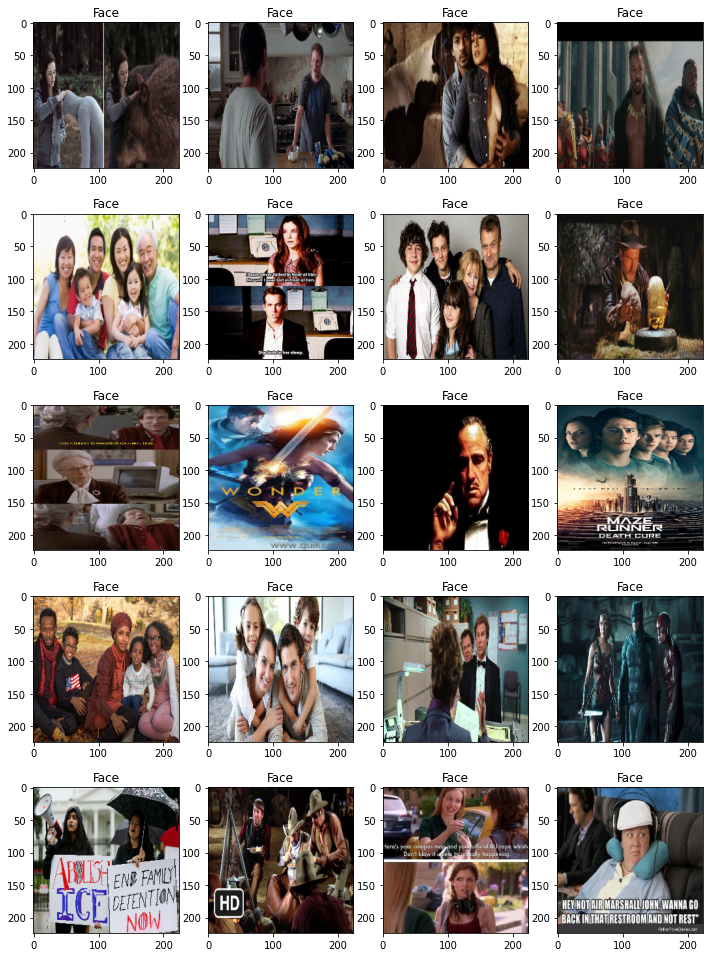

In [ ]:
show_top_images_with_lables(actual_images, target_lables, False)

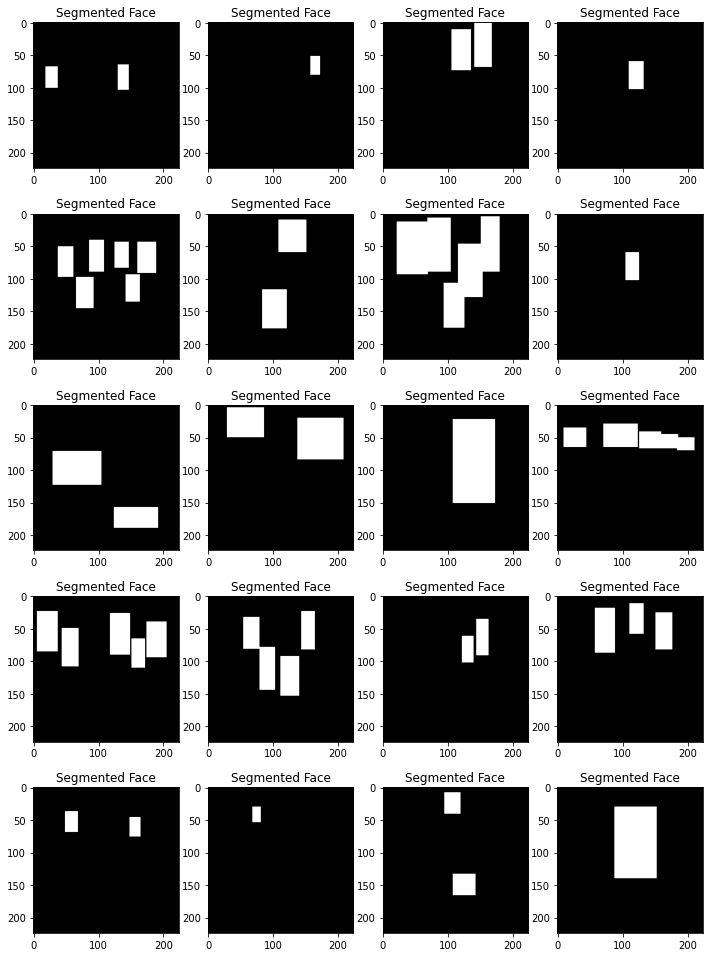

In [ ]:
show_top_images_with_lables(masked_images, masked_target_lables, False)

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.6419753086419753, 'y': 0.3103448275862069}, {'x': 0.7266313932980599, 'y': 0.47648902821316613}], 'imageWidth': 567, 'imageHeight': 319}]


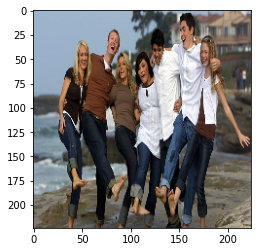

In [ ]:
#@title Put i value to visualise 
i =  401#@param {type:"number"}
plt.imshow(actual_images[i])
print(part_1_dataset[i][1])

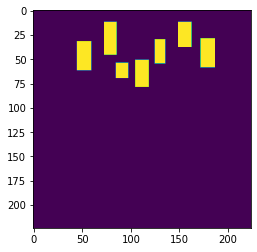

In [ ]:
plt.imshow(masked_images[i])

In [ ]:
processed_inputs = []
print("Processing Inputs....")
for img in tqdm(actual_images):
  processed_inputs.append(preprocess_input(img))
processed_inputs = np.array(processed_inputs)
print("Processing Inputs Finished.")

Processing Inputs....



Processing Inputs Finished.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_inputs, masked_images, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((285, 224, 224, 3), (123, 224, 224, 3), (285, 224, 224), (123, 224, 224))

In [ ]:
model = create_model(False)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [ ]:
optimizer = adm(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
checkpoint = ModelCheckpoint("/content/CheckPoints/Part-1-Checkpoint/model-weights-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True) # To Save the weight of the best performing model
early_stop = EarlyStopping(monitor="val_loss", patience=5) #Stop Early if the model converges very quickly before it over fits.

In [ ]:
#@title No of epochs
#@markdown Change the no of epoch for more training.
no_of_epochs = 100 #@param {type:"number"} 


In [ ]:
with tf.device('/device:GPU:0'):
  model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=no_of_epochs, batch_size=10, verbose=1, callbacks=[checkpoint,early_stop])

Epoch 1/100
29/29 [==============================] - 7s 117ms/step - loss: 2.4289 - dice_coefficient: 0.2247 - val_loss: 2.1828 - val_dice_coefficient: 0.2022

Epoch 00001: val_loss improved from inf to 2.18280, saving model to /content/CheckPoints/Part-1-Checkpoint/model-weights-2.18.h5
Epoch 2/100
29/29 [==============================] - 3s 91ms/step - loss: 1.9909 - dice_coefficient: 0.2371 - val_loss: 1.8744 - val_dice_coefficient: 0.2547

Epoch 00002: val_loss improved from 2.18280 to 1.87443, saving model to /content/CheckPoints/Part-1-Checkpoint/model-weights-1.87.h5
Epoch 3/100
29/29 [==============================] - 3s 91ms/step - loss: 1.7895 - dice_coefficient: 0.2692 - val_loss: 1.6376 - val_dice_coefficient: 0.2986

Epoch 00003: val_loss improved from 1.87443 to 1.63761, saving model to /content/CheckPoints/Part-1-Checkpoint/model-weights-1.64.h5
Epoch 4/100
29/29 [==============================] - 3s 91ms/step - loss: 1.5281 - dice_coefficient: 0.3293 - val_loss: 1.4569 

**Summary Table**
<table>
<thead>
  <tr>
    <td>alpha</td>
    <td>No Epochs</td>
    <td>best-loss</td>
    <td>best-dice-coefficient</td>
    <td>best-val-loss</td>
    <td>best-val-dice-coefficient</td>
    <td>best-weight-saved</td>
    <td>Preprocessed Input</td>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1.0</td>
    <td>50</td>
    <td>0.9537</td>
    <td>0.5089</td>
    <td>1.1224</td>
    <td>0.4550</td>
    <td>model-weights-1.12.h5</td>
    <td>False</td>
  </tr>
  <tr>
    <td>1.0</td>
    <td>100</td>
    <td>1.0430</td>
    <td>0.4714</td>
    <td>1.1855</td>
    <td>0.4299</td>
    <td>model-weights-1.19.h5</td>
    <td>False</td>
  </tr>

  <tr>
    <td>1.0</td>
    <td>50</td>
    <td>0.6838</td>
    <td>0.6210</td>
    <td>0.7056</td>
    <td>0.6162</td>
    <td>model-weights-0.71.h5</td>
    <td>True</td>
  </tr>

  <tr>
    <td>1.0</td>
    <td>100</td>
    <td>0.5864</td>
    <td>0.6725</td>
    <td>0.6713</td>
    <td>0.6334</td>
    <td>model-weights-0.67.h5</td>
    <td>True</td>
  </tr>
</tbody>
</table>

In [ ]:
model_history = model.history.history

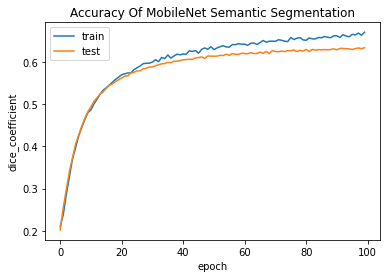

In [ ]:
# summarize history for accuracy
plt.plot(model_history['dice_coefficient'])
plt.plot(model_history['val_dice_coefficient'])
plt.title('Accuracy Of MobileNet Semantic Segmentation')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

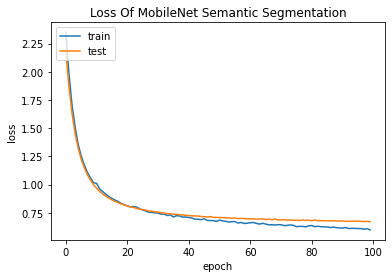

In [ ]:
# summarize history for loss
plt.plot(model_history['loss'])
plt.plot(model_history['val_loss'])
plt.title('Loss Of MobileNet Semantic Segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!mv /content/CheckPoints/Part-1-Checkpoint/*.h5 /content/CheckPoints/Part-1-Checkpoint/Train-4-Weights

In [ ]:
model.save('FaceSemanticSegmentation.h5')

In [ ]:
!cp /content/FaceSemanticSegmentation.h5 /content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-1/FaceSemanticSegmentation.h5
!cp /content/CheckPoints/Part-1-Checkpoint/Train-4-Weights/model-weights-0.67.h5 /content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-1/model-weights-0.67.h5
!cp /content/PredImage.jpeg /content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-1/PredImage.jpeg

In [ ]:
part_1_model = tf.keras.models.load_model('/content/FaceSemanticSegmentation.h5', custom_objects={'loss': loss, 'dice_coefficient': dice_coefficient}) # also can use compile=False if we want to avoid losses to include.
part_1_model.load_weights('/content/CheckPoints/Part-1-Checkpoint/Train-5-Weights/model-weights-0.67.h5')
part_1_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [ ]:
pred_img_path = '/content/PredImage.jpeg'
image_pred = load_img(pred_img_path, target_size=(image_width, image_hight))
image_pred = preprocess_input(np.array(image_pred))
image_pred = np.expand_dims(image_pred, axis=0)
with tf.device('/device:GPU:0'):
  preds = part_1_model.predict(image_pred)

Actual Image To Predict


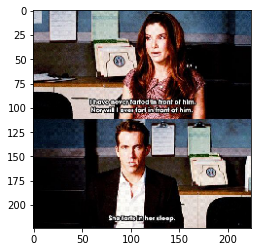

In [ ]:
image_a = load_img(pred_img_path, target_size=(image_width, image_hight))
image_a = np.array(image_a)
plt.imshow(image_a)
print('Actual Image To Predict')

Predicted Image Semantic Segmention


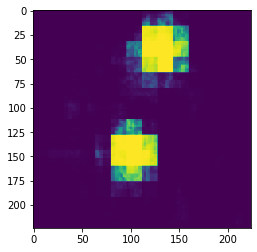

In [ ]:
img_p = preds[0]
plt.imshow(img_p)
print('Predicted Image Semantic Segmention')

<center><h2><b><u>PART-2</u></b></h2></center>
<p>
<b><u>DOMAIN:</u></b> Entertainment
</p>
<p>
  <b><u>CONTEXT:</u></b>: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene
</p>

**Rerading DataSet**

In [ ]:
image_hight = 224
image_width = 224

In [ ]:
data_path = '/content/drive/MyDrive/GreatLearning/CV-Project-2/training_images/'
images_path = glob("{}*".format(data_path))

In [ ]:
file_names = []
images = []
print("Loading Images.....")
for image_path in tqdm(images_path):
  file_name = os.path.split(image_path)[1]
  image = load_img(image_path, (image_width, image_hight))
  image = np.array(image)
  images.append(image)
  file_names.append(file_name)
print("Images Loaded.")

Loading Images.....



Images Loaded.


In [ ]:
dataset = {
    'Images': np.array(images),
    'FileNames': np.array(file_names)
}
data_pickle_file = open('ImageLabling.pkl', 'ab')
pickle.dump(dataset, data_pickle_file)
data_pickle_file.close()

In [ ]:
!cp /content/ImageLabling.pkl /content/drive/MyDrive/GreatLearning/CV-Project-2/SavedData/ImageLabling.pkl

In [ ]:
pickle_path = '/content/drive/MyDrive/GreatLearning/CV-Project-2/SavedData/ImageLabling.pkl'
pkl_file = open(pickle_path, 'rb')
img_ds = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
images_data = img_ds['Images']
filenames_data = img_ds['FileNames']

In [ ]:
images_data.shape, filenames_data.shape

((1091, 600, 600, 3), (1091,))

In [ ]:
resized = []
for image in images_data:
  rs_img = cv2.resize(image, (image_width, image_hight))
  resized.append(rs_img)
resized = np.array(resized)

In [ ]:
resized.shape

(1091, 224, 224, 3)

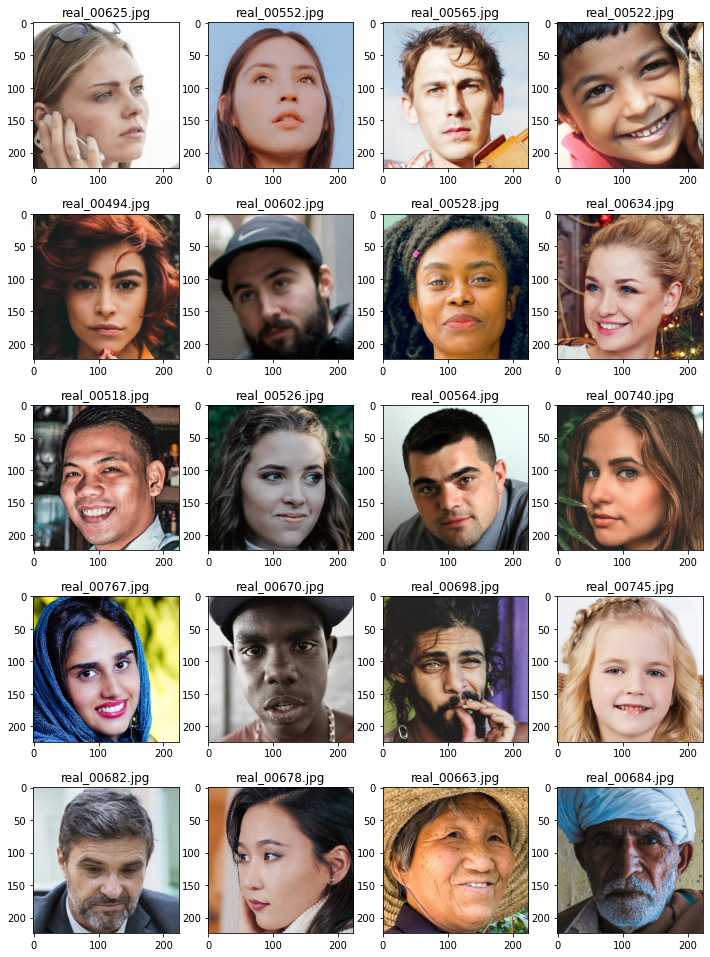

In [ ]:
show_top_images_with_lables(resized, filenames_data, False)

**Method-1 Using Haarcascade**

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
faces_data = []
for index in tqdm(range(len(resized))):
  face_data = [0,0,0,0,0,0,0,0,0,'']
  img_gray = cv2.cvtColor(resized[index],  cv2.COLOR_RGB2GRAY)
  file_name = filenames_data[index]
  faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
  for face in faces:
    face_data[0] = face[0]
    face_data[1] = face[1]
    face_data[2] = face[2]
    face_data[3] = face[3]
    face_data[4] = (face[0]/224)
    face_data[5] = (face[1]/224)
    face_data[6] = (face[2]/224)
    face_data[7] = (face[3]/224)
  face_data[8] = len(faces)
  face_data[9] = file_name
  faces_data.append(face_data)

In [ ]:
faces_data = np.array(faces_data)

In [ ]:
faces_df = pd.DataFrame(faces_data, columns=['x','y','w','h', 'gx','gy', 'gw','gh', 'Total_Faces', 'Image_Name'])
faces_df.head(10)

x   y    w    h  ...        gw        gh  Total_Faces      Image_Name
0   0   0    0    0  ...  0.000000  0.000000            0  real_00625.jpg
1  37  24  165  165  ...  0.736607  0.736607            1  real_00552.jpg
2  32  41  153  153  ...  0.683036  0.683036            1  real_00565.jpg
3   0   0    0    0  ...  0.000000  0.000000            0  real_00522.jpg
4  34  48  160  160  ...  0.714286  0.714286            1  real_00494.jpg
5   0   0    0    0  ...  0.000000  0.000000            0  real_00602.jpg
6  32  33  168  168  ...  0.750000  0.750000            1  real_00528.jpg
7  17  64  136  136  ...  0.607143  0.607143            1  real_00634.jpg
8  24  55  147  147  ...  0.656250  0.656250            1  real_00518.jpg
9  50  48  157  157  ...  0.700893  0.700893            1  real_00526.jpg

[10 rows x 10 columns]

In [ ]:
faces_df.to_csv('HaarcascadeMethod.csv', index=False)

In [ ]:
!cp /content/HaarcascadeMethod.csv /content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-2/HaarcascadeMethod.csv

In [ ]:
with open('HaarcascadeMethodFaceDataset.npy', 'wb') as f:
  np.save(f, faces_data)

In [ ]:
!cp /content/HaarcascadeMethodFaceDataset.npy /content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-2/HaarcascadeMethodFaceDataset.npy

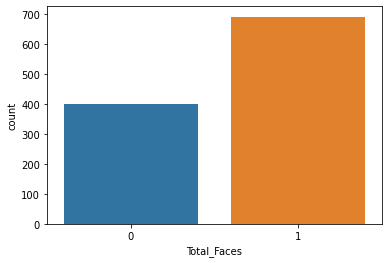

In [ ]:
sns.countplot(faces_df['Total_Faces'])

**Method-2 Using above Trainied Deeplearning model.**

In [ ]:
segmented_model = tf.keras.models.load_model('/content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-1/FaceSemanticSegmentation.h5', compile=False)
segmented_model.load_weights('/content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-1/model-weights-0.67.h5')

In [ ]:
face_segmented = []
print("Generating Coordinates..")
for face_image in tqdm(resized):
  with tf.device('/device:GPU:0'):
    processed_input = preprocess_input(face_image)
    processed_input = np.array(processed_input)
    processed_input = np.expand_dims(processed_input, axis=0)
    predict = segmented_model.predict(processed_input)
    face_segmented.append(predict[0])
print("Done")
face_segmented = np.array(face_segmented)

Generating Coordinates..



Done


x: 30, y: 6, w: 156 h: 204


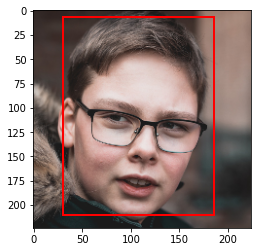

face_count: 1


In [ ]:
#@title Input i value { vertical-output: true, form-width: "400px" }
i =  414#@param {type:"integer"}

new_cp_img = face_segmented[i]
norm_new_cp_img = cv2.normalize(new_cp_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_new_cp_img = norm_new_cp_img.astype(np.uint8)

_, difference = cv2.threshold(norm_new_cp_img, 200, 255, cv2.THRESH_BINARY)
difference = cv2.dilate(difference, None, iterations=2)
contours, hierarchy = cv2.findContours(difference.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

face_count = 0
for count in contours:
  if cv2.contourArea(count) < 3000:
    continue
  (x, y, w, h) =  cv2.boundingRect(count)
  print(f"x: {x}, y: {y}, w: {(w)} h: {(h)}")
  face_count = face_count+1
  fig,ax = plt.subplots(1)
  ax.imshow(resized[i]) # Display the image
  rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()
print(f"face_count: {face_count}")

In [ ]:
face_coodrinates_data = []
for i in tqdm(range(len(face_segmented))):
  mface_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, '']
  face_count = 0
  seg_img = face_segmented[i]
  file_name = filenames_data[i]
  norm_img = cv2.normalize(seg_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  norm_img = norm_img.astype(np.uint8)
  _, difference = cv2.threshold(norm_img, 200, 255, cv2.THRESH_BINARY)
  difference = cv2.dilate(difference, None, iterations=2)
  contours, _ = cv2.findContours(difference.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for count in contours:
    if cv2.contourArea(count) < 3000:
      continue
    (x, y, w, h) =  cv2.boundingRect(count)
    mface_data[0] = x
    mface_data[1] = y
    mface_data[2] = w
    mface_data[3] = h
    mface_data[4] = x/224
    mface_data[5] = y/224
    mface_data[6] = w/224
    mface_data[7] = h/224
    face_count = face_count+1
  mface_data[8] = face_count
  mface_data[9] = file_name
  face_coodrinates_data.append(mface_data)

In [ ]:
face_coodrinates_data = np.array(face_coodrinates_data)

In [ ]:
face_coodrinates_df = pd.DataFrame(face_coodrinates_data, columns=['x','y','w','h', 'gx','gy', 'gw','gh', 'Total_Faces', 'Image_Name'])
face_coodrinates_df.head(15)

x   y    w  ...                  gh Total_Faces      Image_Name
0   30  46  156  ...  0.7946428571428571           1  real_00625.jpg
1   30  14  164  ...  0.8035714285714286           1  real_00552.jpg
2   30   6  156  ...  0.8392857142857143           1  real_00565.jpg
3    6  30  172  ...  0.7678571428571429           1  real_00522.jpg
4   56  30  138  ...  0.8660714285714286           1  real_00494.jpg
5   30  62  132  ...  0.6607142857142857           1  real_00602.jpg
6   36  30  158  ...  0.8571428571428571           1  real_00528.jpg
7   30  30  164  ...  0.8392857142857143           1  real_00634.jpg
8   38  30  158  ...  0.8660714285714286           1  real_00518.jpg
9   50  14  144  ...               0.875           1  real_00526.jpg
10  30  30  156  ...  0.8660714285714286           1  real_00564.jpg
11  30  14  120  ...  0.9285714285714286           1  real_00740.jpg
12  22  24  140  ...  0.8303571428571429           1  real_00767.jpg
13  30  30  156  ...  0.8571428571428571           1  real_00670.jpg
14  46  50  116  ...  0.5357142857142857           1  real_00698.jpg

[15 rows x 10 columns]

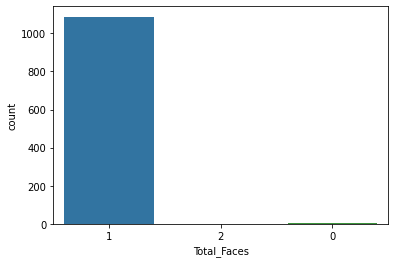

In [ ]:
sns.countplot(face_coodrinates_df['Total_Faces'])

In [ ]:
face_coodrinates_df.to_csv('FaceDataDeepLearningMethod.csv', index=False)

In [ ]:
!cp /content/FaceDataDeepLearningMethod.csv /content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-2/FaceDataDeepLearningMethod.csv

In [ ]:
with open('DeepLearningMethodFaceDataset.npy', 'wb') as datafile:
  np.save(datafile, face_coodrinates_data)

In [ ]:
!cp /content/DeepLearningMethodFaceDataset.npy /content/drive/MyDrive/SharedData/CV-2-SavedWeights/Part-2/DeepLearningMethodFaceDataset.npy

<p> <b>Conclusion:</b>
Determining face co-ordinates with haarcascade method is less accurate comparing to deeplearning like we can see the count plot for both of the models the where haarcascade is unable to find the faces for more than 360 faces and pre-trained deeplearning model was able to find almost all of the faces with higher accuracy.
</p>

<p>
  
</p>

<center><h2><b><u>PART-3</u></b></h2></center>
<p>
<b><u>DOMAIN:</u></b> Face recognition
</p>
<p>
  <b><u>CONTEXT:</u></b> Company X intends to build a face identification model to recognise human faces
</p>

In [ ]:
dataset_base_path = '/content/drive/MyDrive/GreatLearning/CV-Project-2/PINS/'
faces_data_path = '{}*/*'.format(dataset_base_path)

In [ ]:
image_hight = 224
image_width = 224

In [ ]:
faces_data_full_path = glob(faces_data_path)

In [ ]:
images_data = []
lables_data = []
for path in tqdm(faces_data_full_path):
  with tf.device('/device:GPU:0'):
    class_name = os.path.basename(os.path.dirname(os.path.normpath(path)))
    class_name = class_name.replace('pins_', '')
    class_name = class_name.replace('_', ' ')
    person_img = load_img(path, target_size=(image_width, image_hight), color_mode='rgb')
    person_img = np.array(person_img)
    images_data.append(person_img)
    lables_data.append(class_name)
images_data = np.array(images_data)
lables_data = np.array(lables_data)

In [ ]:
face_dataset = {
    'FaceImage': images_data,
    'Lables': lables_data
}
with open('FaceRecognisionDataSetPickled.pkl', 'ab') as data_pickle_file:
  pickle.dump(face_dataset, data_pickle_file)


In [ ]:
!cp /content/FaceRecognisionDataSetPickled.pkl /content/drive/MyDrive/GreatLearning/CV-Project-2/SavedData/FaceRecognisionDataSetPickled.pkl

In [ ]:
face_dataset_path = '/content/drive/MyDrive/GreatLearning/CV-Project-2/SavedData/FaceRecognisionDataSetPickled.pkl'

In [ ]:
with open(face_dataset_path, 'rb') as ds_reader:
  dataset = pickle.load(ds_reader)

In [ ]:
image_dataset = dataset['FaceImage']
lable_dataset = dataset['Lables']

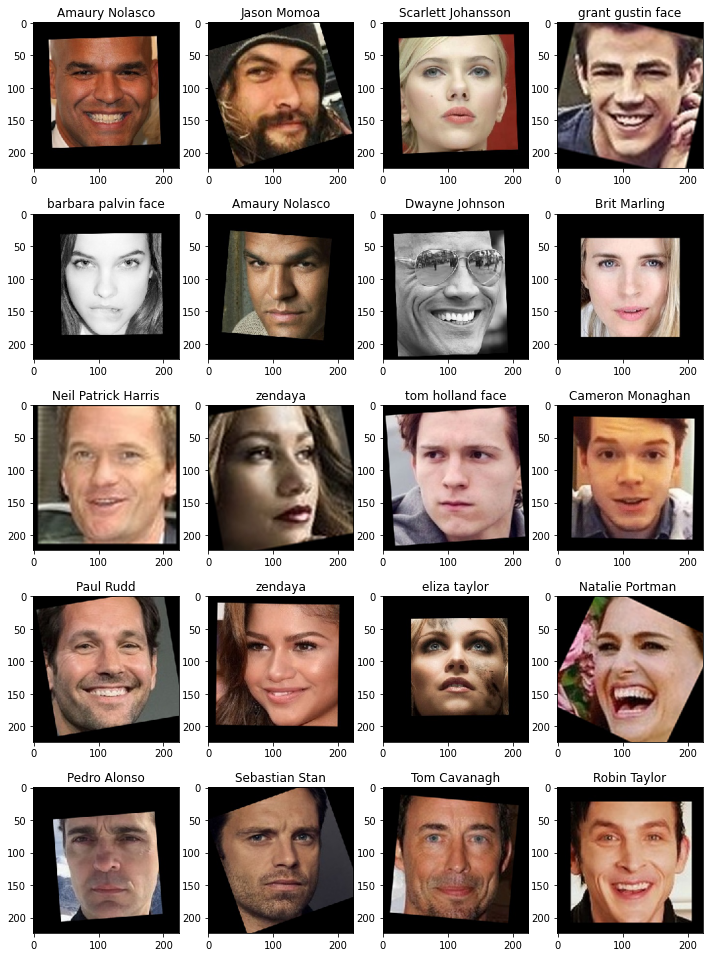

In [ ]:
show_top_images_with_lables(image_dataset, lable_dataset)

In [ ]:
image_dataset.shape, lable_dataset.shape

((10770, 224, 224, 3), (10770,))

In [ ]:
vgg_face_model = Sequential()
vgg_face_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
vgg_face_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
vgg_face_model.add(ZeroPadding2D((1,1)))	
vgg_face_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(ZeroPadding2D((1,1)))
vgg_face_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face_model.add(MaxPooling2D((2,2), strides=(2,2)))
vgg_face_model.add(Convolution2D(4096, (7, 7), activation='relu'))
vgg_face_model.add(Dropout(0.5))
vgg_face_model.add(Convolution2D(4096, (1, 1), activation='relu'))
vgg_face_model.add(Dropout(0.5))
vgg_face_model.add(Convolution2D(2622, (1, 1)))
vgg_face_model.add(Flatten())
vgg_face_model.add(Activation('softmax'))

In [ ]:
# Load VGG Face model weights
vgg_face_model.load_weights('/content/drive/MyDrive/GreatLearning/CV-Project-2/Part-3-Weights/vgg_face_weights.h5')

In [ ]:
def get_embeddings(image_data):
  with tf.device('/device:GPU:0'):
    preprocessed = imagenet_preprocess_input(image_data)
    embeddings = vgg_face_model.predict(preprocessed)
  return embeddings

In [ ]:
def get_embedding(image):
  with tf.device('/device:GPU:0'):
    img = np.expand_dims(image, axis=0)
    preprocessed = imagenet_preprocess_input(img)
    embedding = vgg_face_model.predict(preprocessed)
  return embedding

In [ ]:
face_embeddings = get_embeddings(image_dataset)

In [ ]:
pd.DataFrame(face_embeddings).head(5)

0             1         2     ...      2619      2620      2621
0  0.006693  6.260776e-06  0.000005  ...  0.000073  0.000046  0.000167
1  0.000204  4.817874e-07  0.000005  ...  0.000005  0.000007  0.000145
2  0.014802  5.395867e-05  0.000019  ...  0.000371  0.000030  0.000176
3  0.082052  1.416648e-05  0.000015  ...  0.000048  0.000020  0.000062
4  0.017784  3.217556e-05  0.000067  ...  0.000078  0.000119  0.000270

[5 rows x 2622 columns]

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
from scipy.spatial.distance import cosine, euclidean

In [ ]:
from math import*
 
def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
 
def cosine_similarity(x,y):
   numerator = sum(a*b for a,b in zip(x,y))
   denominator = square_rooted(x)*square_rooted(y)
   return round(numerator/float(denominator),3)

def euclidean_distance(x, y):
    '''Compute Euclidean Distance between two vectors'''
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


In [ ]:
lbl_encoder = LabelEncoder()
encoderd_lables = lbl_encoder.fit_transform(lable_dataset)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(face_embeddings, encoderd_lables, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8616, 2622), (2154, 2622), (8616,), (2154,))

In [ ]:
pca =PCA(n_components=700)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
pca.explained_variance_ratio_.sum()

0.9884025

In [ ]:
X_train_pca[0].shape, X_test_pca[0].shape

((700,), (700,))

In [ ]:
with tf.device('/device:GPU:0'):
  svc = SVC()
  svc.fit(X_train_pca, y_train)
  print(svc)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
svc_pred = svc.predict(X_test_pca)

In [ ]:
print("Classification Report SVM")
print(classification_report(y_test, svc_pred))

Classification Report SVM
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        18
           1       0.75      0.50      0.60        18
           2       0.94      0.84      0.89        19
           3       1.00      1.00      1.00        24
           4       1.00      0.89      0.94        18
           5       1.00      0.61      0.76        18
           6       1.00      0.47      0.64        17
           7       0.79      0.93      0.86        29
           8       1.00      0.82      0.90        22
           9       0.62      0.45      0.53        11
          10       0.75      0.88      0.81        17
          11       1.00      0.67      0.80        24
          12       0.85      0.73      0.79        15
          13       0.69      0.73      0.71        15
          14       0.94      0.61      0.74        28
          15       0.77      0.69      0.73        29
          16       0.95      0.72      0.82        25
 

CONFUSION MATRIX FOR FACE RECOGNITION SVM




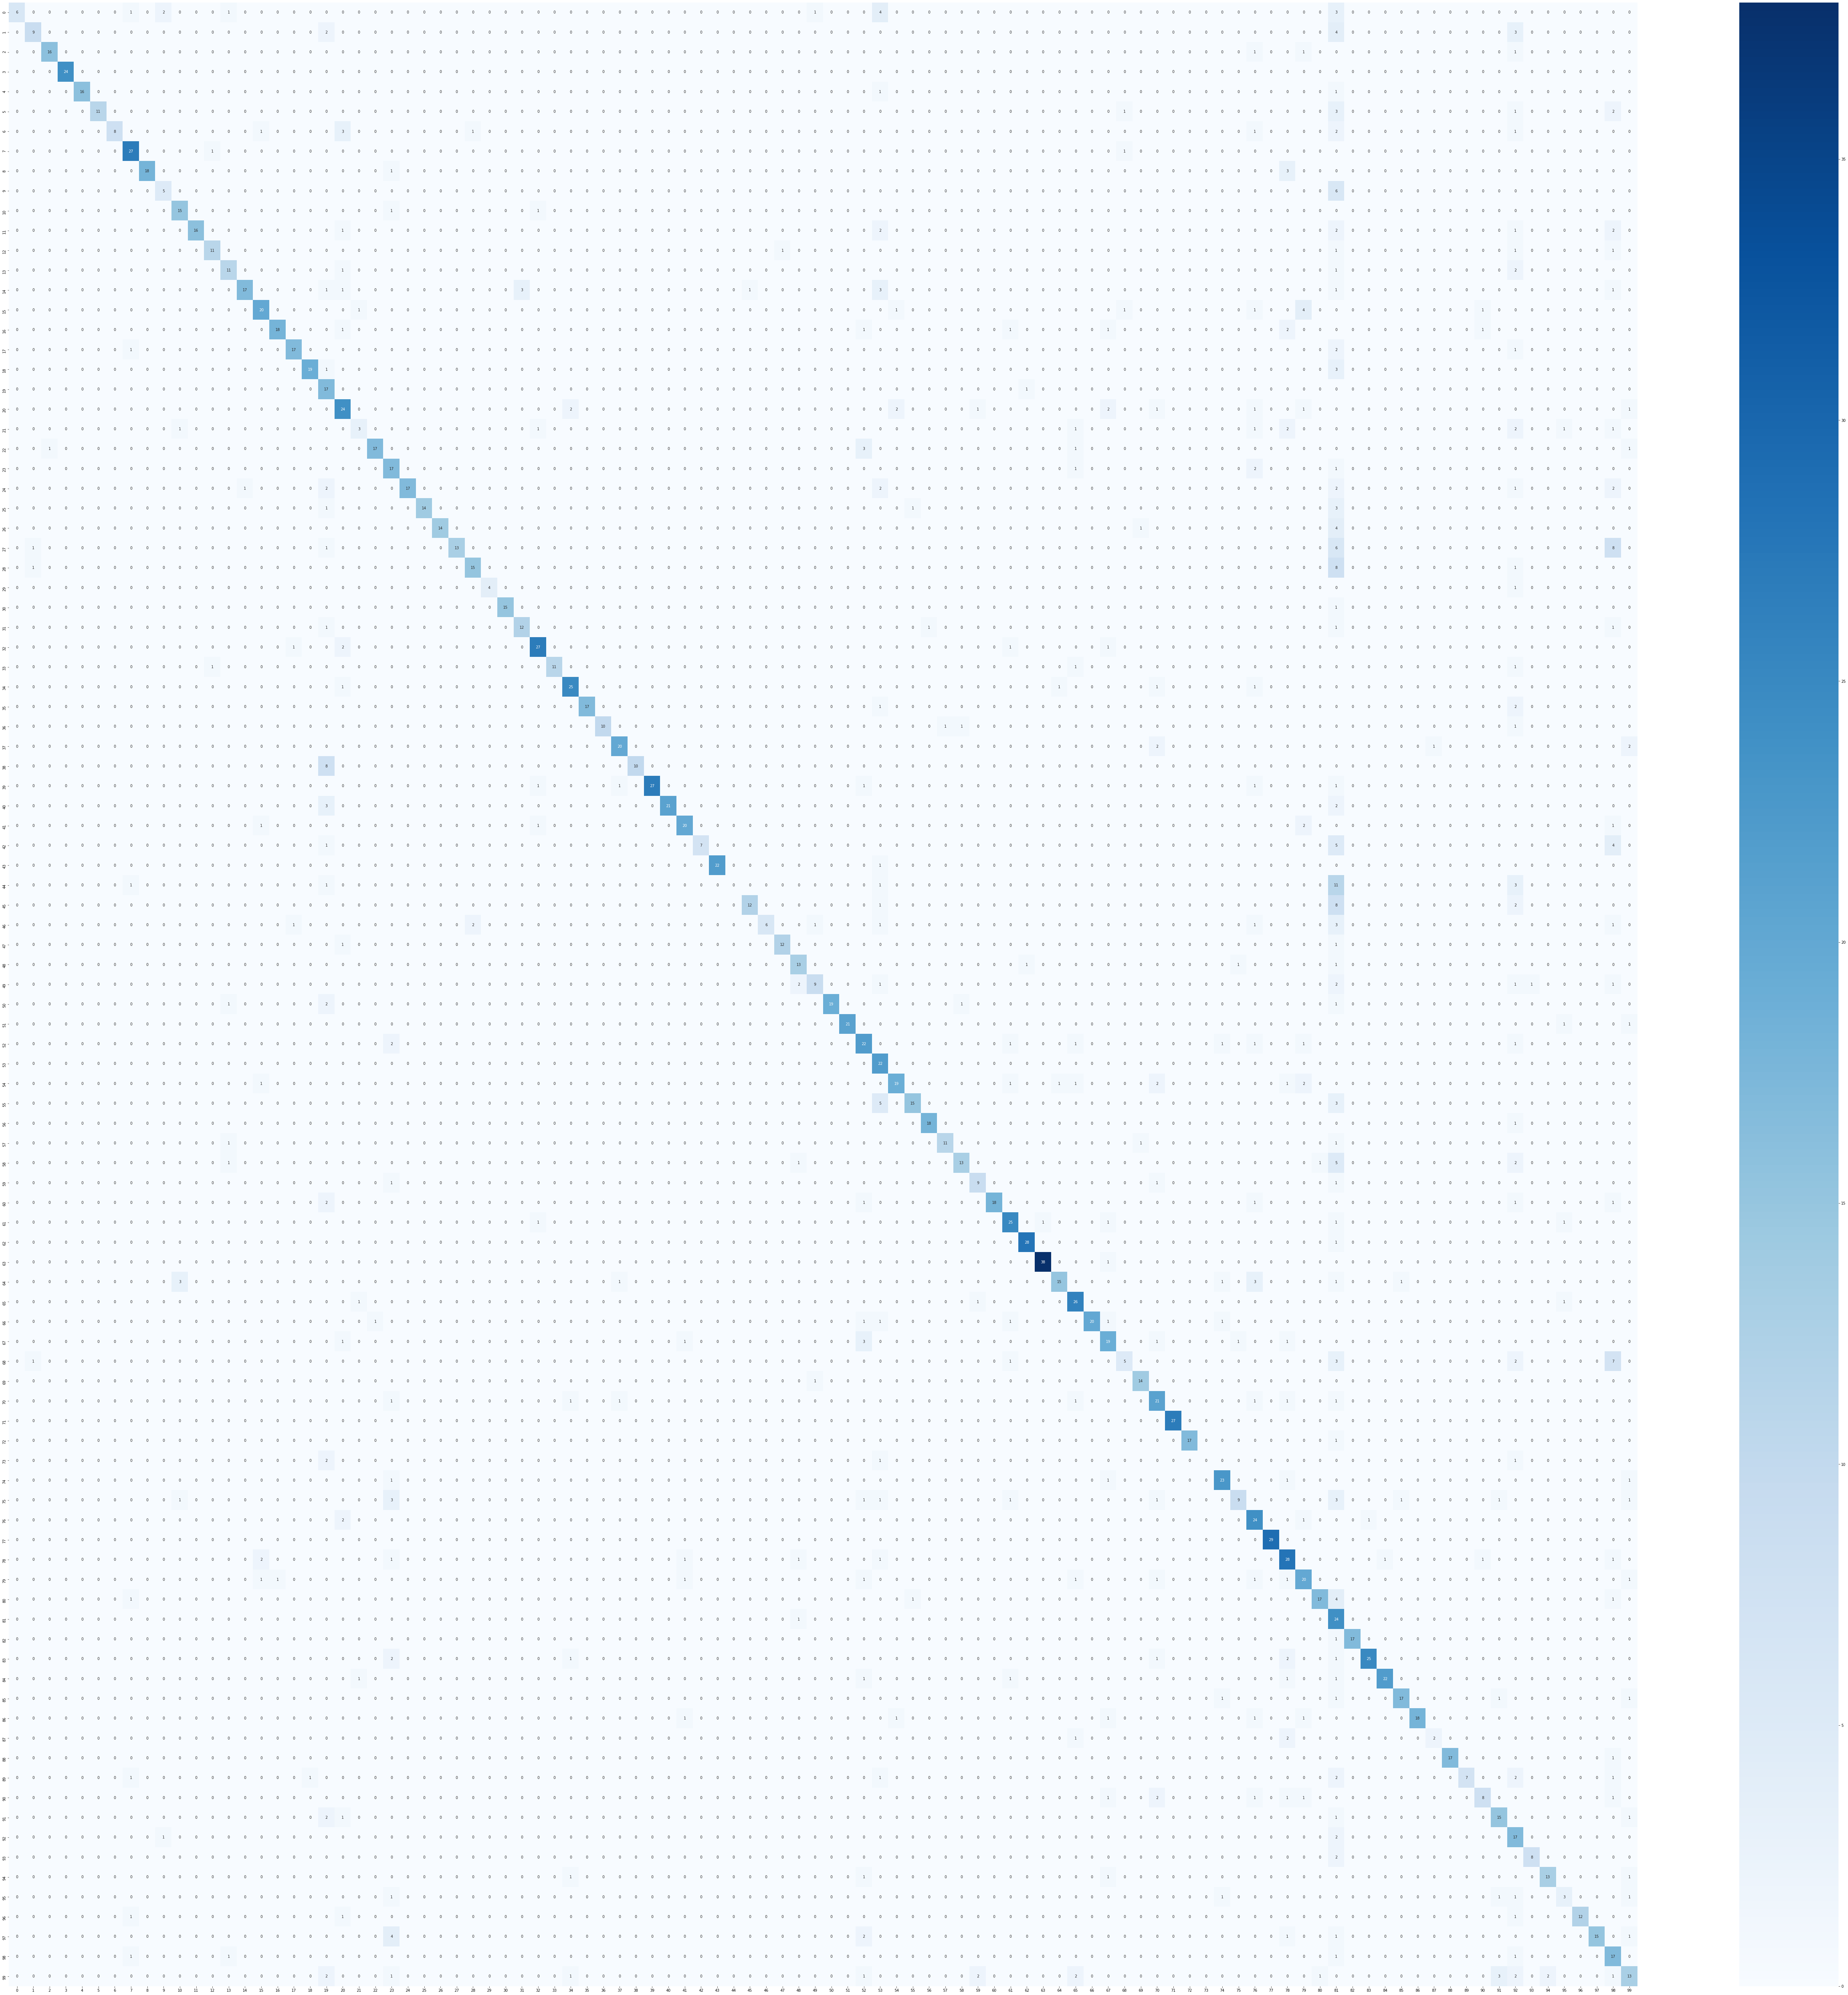

In [ ]:
confusion_matrix_svm = confusion_matrix(y_test, svc_pred)
confusion_matrix_svm_df = pd.DataFrame(confusion_matrix_svm)
plt.figure(figsize=(100,100))
sns.heatmap(confusion_matrix_svm_df, annot=True, cmap='Blues', fmt='g')
print("CONFUSION MATRIX FOR FACE RECOGNITION SVM")
print("\n")

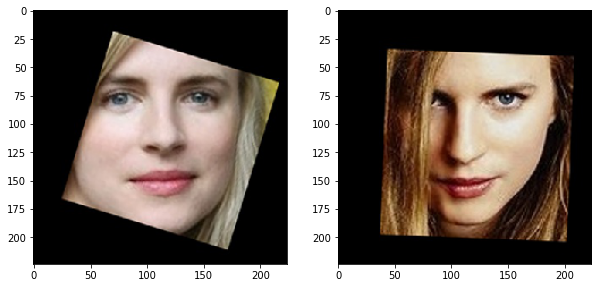


SVM-PREDICT: Brit Marling ACTUAL: Brit Marling

Euclidean Distance between Embedding is: 0.1809810996055603

Cosine Similarity between Embedding is: 0.024103760719299316

Reference Image and Predict Image are of same person


In [ ]:
#@title Insert image posiotion { vertical-output: true }
reference_img =  850#@param {type:"integer"}
predict_img =  840#@param {type:"integer"}
thrush_hold = 0.2 #@param {type:"raw"}
img1 = image_dataset[reference_img]
img2 = image_dataset[predict_img]
embedding1 = get_embedding(img1)
embedding2 = get_embedding(img2)
pca_e2 = pca.transform(embedding2)
pca_e1 = pca.transform(embedding1)
svc_pred_op = svc.predict(pca_e2)
person = lbl_encoder.classes_[svc_pred_op]
dist = euclidean(pca_e1, pca_e2)
cos_sim = cosine(pca_e1, pca_e2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()
print("")
print(f'SVM-PREDICT: {lbl_encoder.classes_[svc_pred_op][0]} ACTUAL: {lable_dataset[predict_img]}')
print("")
print(f'Euclidean Distance between Embedding is: {dist}')
print("")
print(f'Cosine Similarity between Embedding is: {cos_sim}')
print("")
if cos_sim < thrush_hold:
  print('Reference Image and Predict Image are of same person')
else:
  print('Reference Image and Predict Image are not of same person')

<center><h2><b><u>PART-4</u></b></h2></center>
<p>
<b><u>DOMAIN:</u></b> State traffic department
</p>
<p>
  <b><u>CONTEXT:</u></b> City X’s traffic department wants to understand the traffic density on road during busy hours in order to efficiently program
their traffic lights. 
</p>

In [23]:
!wget https://pjreddie.com/media/files/yolov3.weights
!cp /content/yolov3.weights /content/drive/MyDrive/GreatLearning/CV-Project-2/Part-4-Weights/yolov3.weights

--2021-02-24 07:25:56--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.7MB/s    in 13s     

2021-02-24 07:26:09 (18.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [2]:
model_configuration = '/content/drive/MyDrive/GreatLearning/CV-Project-2/Part-4-Weights/yolo.cfg'
model_weights = '/content/drive/MyDrive/GreatLearning/CV-Project-2/Part-4-Weights/yolov3.weights'
labels_path = '/content/drive/MyDrive/GreatLearning/CV-Project-2/Part-4-Weights/coco-labels'

In [3]:
confidence_threshold = 0.5
nms_threshold = 0.3

In [4]:
coco_labels = open(labels_path).read().strip().split('\n')

In [5]:
video_name = "video1.mp4"#@param {type: "string"}
video_path = f'/content/drive/MyDrive/GreatLearning/CV-Project-2/Video/{video_name}'
video = cv2.VideoCapture(video_path)

In [6]:
net = cv2.dnn.readNetFromDarknet(model_configuration, model_weights)
outputLayer = net.getLayerNames()
outputLayer = [outputLayer[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [7]:
writer = None
(W, H) = (None, None)

In [8]:
with tf.device('/device:GPU:0'):
  count = 0
  while video.read()[0]:
      (ret, frame) = video.read()
      if W is None or H is None:
          (H,W) = frame.shape[:2]
      blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB = True, crop = False)
      net.setInput(blob)
      layersOutputs = net.forward(outputLayer)

      boxes = []
      confidences = []
      classIDs = []

      for output in layersOutputs:
          for detection in output:
              scores = detection[5:]
              classID = np.argmax(scores)
              confidence = scores[classID]
              if confidence > confidence_threshold:
                  box = detection[0:4] * np.array([W, H, W, H])
                  (centerX, centerY,  width, height) = box.astype('int')
                  x = int(centerX - (width/2))
                  y = int(centerY - (height/2))

                  boxes.append([x, y, int(width), int(height)])
                  confidences.append(float(confidence))
                  classIDs.append(classID)

      #Apply Non Maximal Suppression
      detectionNMS = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
      if(len(detectionNMS) > 0):
          for i in detectionNMS.flatten():
              (x, y) = (boxes[i][0], boxes[i][1])
              (w, h) = (boxes[i][2], boxes[i][3])

              color = (224,10,10)
              cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
              text = '{}: {:.4f}'.format(coco_labels[classIDs[i]], confidences[i])
              cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

      if writer is None:
          fourcc = cv2.VideoWriter_fourcc(*'MJPG')
          writer = cv2.VideoWriter('{}_boxed.avi'.format(video_name.replace('.mp4', '')), fourcc, 30, (frame.shape[1], frame.shape[0]), True)
      if writer is not None:
          writer.write(frame)
          count = count + 1
  print(count)

1324


In [9]:
writer.release()
video.release()

In [10]:
!cp /content/video1_boxed.avi /content/drive/MyDrive/GreatLearning/CV-Project-2/Video/video1_boxed.avi

In [11]:
!jupyter nbconvert --to html /content/drive/MyDrive/'Colab Notebooks'/CV-Project7.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/CV-Project7.ipynb to html
[NbConvertApp] Writing 5085680 bytes to /content/drive/MyDrive/Colab Notebooks/CV-Project7.html
